#### python kernel : 3.9.7

######### Prophet_train 과 다른 점 : 데이터 5100값이하들을 선형보간법으로 대체, 날짜 다시 맵핑하여 비어 있는 값들도 선형 보간법으로 대체

sudo apt-get install python3-pip

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet

#### 학습용 데이터 서버 업로드 (stfp를 이용)  
1.  (linux server) mkdir "폴더명"   
2.  (Window local) cmd 창 : 파일 디렉터리로 이동 -> sftp [ID]@[서버주소] -> pw 입력 -> 리눅스 서버 디렉터리 이동 -> put(window local 파일명) 

학습데이터 불러오기


In [8]:
#data 불러오기
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')   #pip install openpyxl 

In [9]:
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
print(data.info(),data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB
None 기준시각           0
직전 15분 사용전력    0
dtype: int64


#날짜별 결측치 확인

In [11]:
#daterange
dates = pd.date_range('2021-04-01 00:00:00', periods=43776, freq='15min')
dates = pd.DataFrame(dates,columns=['기준시각'])

#leftjoin
datas=pd.merge(dates,data,how='left',on='기준시각')

print(datas.isna().sum(), datas['직전 15분 사용전력'].min(),datas['직전 15분 사용전력'].max(),datas['직전 15분 사용전력'].median())

datas
datas.info()

기준시각              0
직전 15분 사용전력    1010
dtype: int64 571.2 8820.0 7341.6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43776 entries, 0 to 43775
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         43776 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


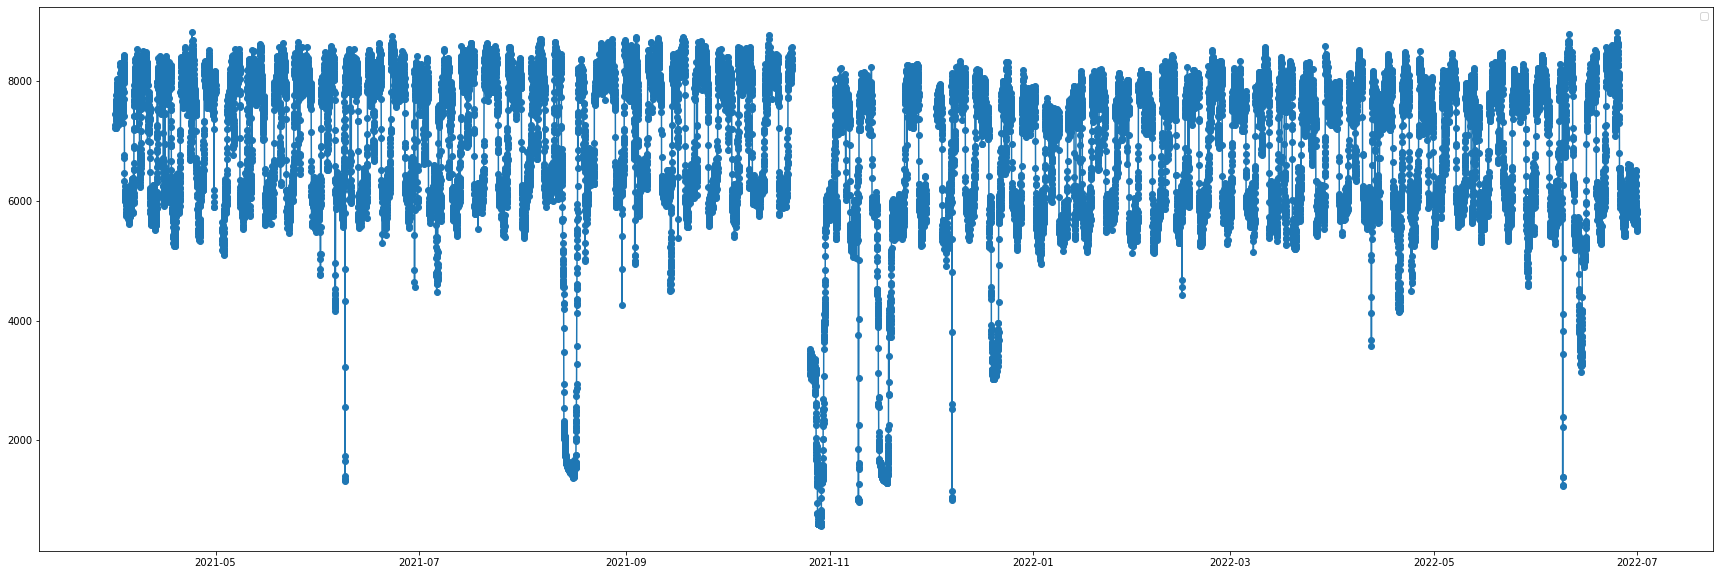

In [12]:
# 기존 데이터 그래프(결측 처리 전)
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


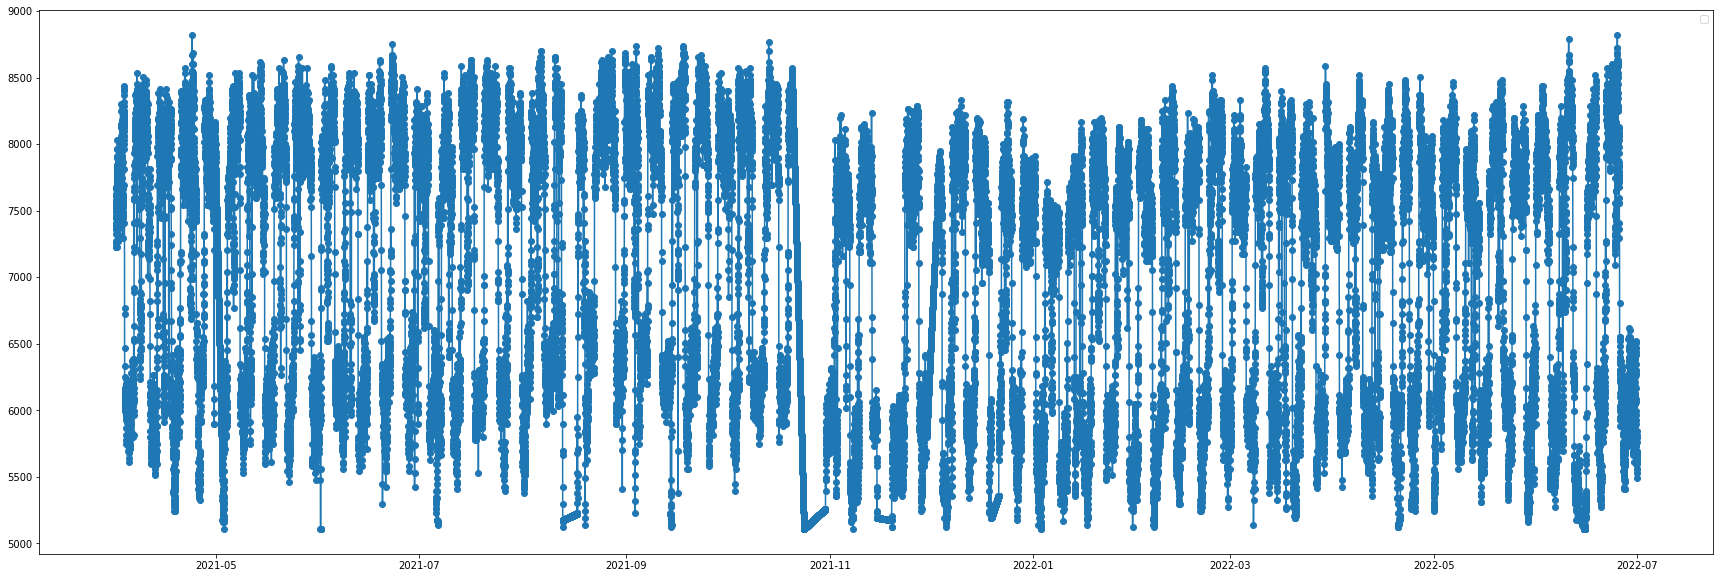

In [14]:
# 5100 이하값들은 이전 값들로 대체
import numpy as np
datas.loc[(datas['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
datas.isna().sum()

# 선형 보간(linear) : 이상치,5100이하 na값 후
from scipy import interpolate
datas['직전 15분 사용전력']=datas['직전 15분 사용전력'].interpolate()

#보간후
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()


module 불러오기 (git 연동 & clone 후 )


('/home/ykkim/Baseline_Analysis/4. Supervised_model/neural_prophet_module.py')

In [34]:
import sys
sys.path.append('/home/ykkim/Baseline_Analysis/4. Supervised_model/' )  #모듈 저장 위치 지정 
print(sys.path)

['/home/ykkim/.jupyter', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python39.zip', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/lib-dynload', '', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages', '/home/ykkim/Baseline_Analysis/4. Supervised_model/', '/home/ykkim/Baseline_Analysis/4. Supervised_model/']


In [35]:
import neural_prophet_module as NP

In [36]:
#lag, diff feature 생성
NP.gen_feature_lag(datas,'직전 15분 사용전력','l_1',1)
NP.gen_feature_lag(datas,'직전 15분 사용전력','l_2',2)
NP.gen_feature_lag(datas,'직전 15분 사용전력','l_3',3)
NP.gen_feature_lag(datas,'직전 15분 사용전력','l_4',4)
NP.gen_feature_lag(datas,'직전 15분 사용전력','l_5',5)


NP.gen_feature_diff(datas,'직전 15분 사용전력','d_1',1)
NP.gen_feature_diff(datas,'직전 15분 사용전력','d_2',2)


,기준시각,직전 15분 사용전력,l_1,l_2,l_3,l_4,l_5,d_1,d_2
0,2021-04-01 00:00:00,7224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7274.4,7224.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7442.4,7274.4,7224.0,NaN,NaN,NaN,50.4,NaN
3,2021-04-01 00:45:00,7392.0,7442.4,7274.4,7224.0,NaN,NaN,168.0,218.4
4,2021-04-01 01:00:00,7576.8,7392.0,7442.4,7274.4,7224.0,NaN,-50.4,117.6
...,...,...,...,...,...,...,...,...,...
43771,2022-06-30 22:45:00,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,50.4,0.0
43772,2022-06-30 23:00:00,5560.8,5628.0,5644.8,5594.4,5644.8,5678.4,-16.8,33.6
43773,2022-06-30 23:15:00,5493.6,5560.8,5628.0,5644.8,5594.4,5644.8,-67.2,-84.0
43774,2022-06-30 23:30:00,5527.2,5493.6,5560.8,5628.0,5644.8,5594.4,-67.2,-134.4


In [37]:
# train_test split
df_train,df_test=NP.train_test_split(datas,Time_name='기준시각',train_cut_date='2022-06-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='N')  #validation set은 추후에 분리

train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 43680
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


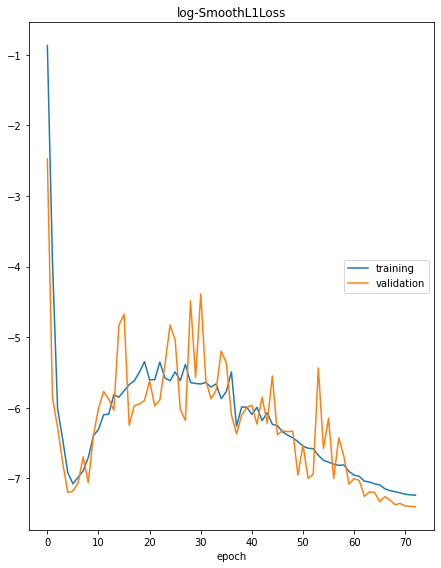

log-SmoothL1Loss
	training         	 (min:   -7.239, max:   -0.867, cur:   -7.239)
	validation       	 (min:   -7.402, max:   -2.475, cur:   -7.402)
SmoothL1Loss:  0.0007180178256852853
MAE(Train):  85.28249097365308
MAE(val):  83.42613088866293


In [38]:
#모델 학습
model, metrics= NP.NP_model(df_train,df_test,Time_name='기준시각',Y_name='직전 15분 사용전력',num_futureregressor=7,val_p=0.1)   # pip install livelossplot

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster

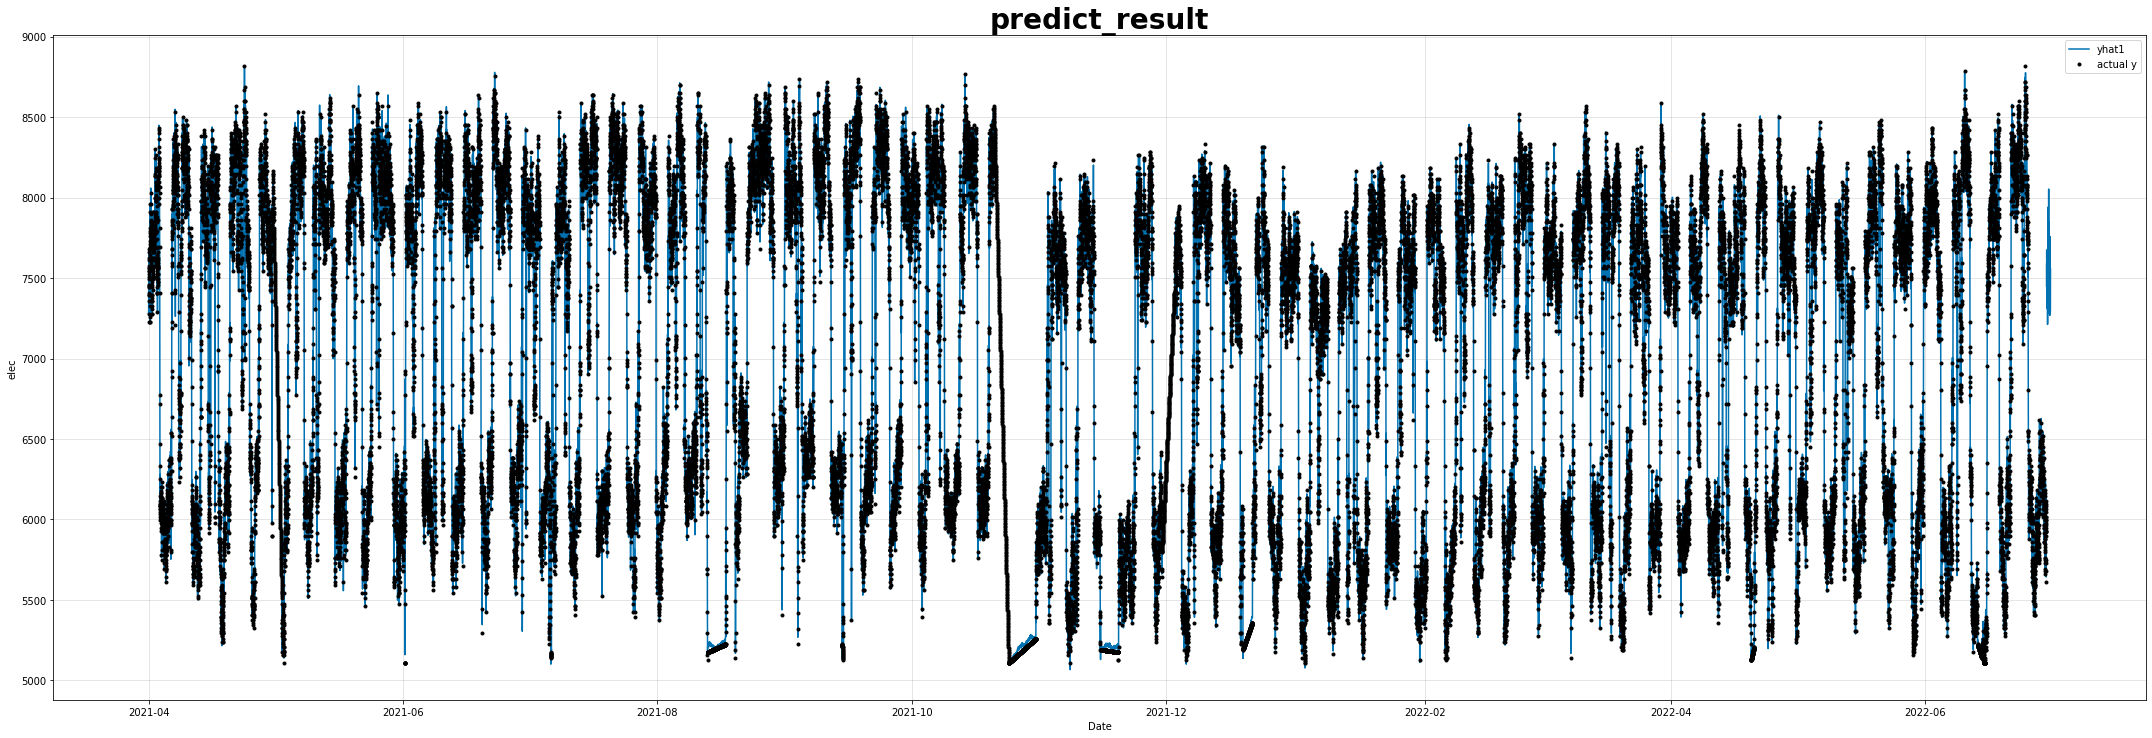

In [39]:
#train 후 예측
forecast=NP.NP_model_predict(df_train,model,num_futureregressor=7,predict_period=96) #하루치 예측

In [40]:
forecast.tail(96)

,ds,y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_d_1,future_regressor_d_2,future_regressor_l_1,future_regressor_l_2,future_regressor_l_3,future_regressor_l_4,future_regressor_l_5
43680,2022-06-30 00:00:00,NaN,NaN,NaN,4090.498047,3.914034,3.088844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43681,2022-06-30 00:15:00,NaN,NaN,NaN,4090.497803,3.772778,0.948705,NaN,NaN,NaN,1306.747681,NaN,NaN,NaN,NaN
43682,2022-06-30 00:30:00,NaN,NaN,NaN,4090.497559,3.637187,-1.377077,NaN,702.539673,NaN,1337.860718,269.417572,NaN,NaN,NaN
43683,2022-06-30 00:45:00,NaN,NaN,NaN,4090.497070,3.507373,-3.488916,NaN,745.302917,389.368195,1441.570923,275.832245,471.215515,NaN,NaN
43684,2022-06-30 01:00:00,NaN,NaN,NaN,4090.496826,3.383440,-5.022253,NaN,665.885437,375.941711,1410.457886,297.214600,482.434937,-19.274284,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2022-06-30 22:45:00,NaN,7292.793945,NaN,4090.467773,14.559213,1.848088,3185.919189,617.013123,342.375488,1358.602783,303.629333,519.832947,-21.874781,66.340462
43772,2022-06-30 23:00:00,NaN,7469.792480,NaN,4090.467285,14.800560,3.919507,3360.604980,726.975891,351.326508,1431.199951,280.108734,531.052368,-21.262901,61.204433
43773,2022-06-30 23:15:00,NaN,7537.090820,NaN,4090.467041,15.039159,5.161763,3426.422607,720.866760,389.368195,1493.426025,295.076355,489.914551,-21.721811,59.492420
43774,2022-06-30 23:30:00,NaN,7489.798340,NaN,4090.466797,15.274805,5.413892,3378.643066,671.994446,369.228485,1472.683960,307.905792,516.093201,-20.039137,60.776428


In [41]:
# predict, real 비교 dataframe
result_df=NP.result_df(df_test,forecast)
result_df


,ds,y_x,y_y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_d_1,future_regressor_d_2,future_regressor_l_1,future_regressor_l_2,future_regressor_l_3,future_regressor_l_4,future_regressor_l_5
0,2022-06-30 00:00:00,5846.4,NaN,NaN,NaN,4090.498047,3.914034,3.088844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-06-30 00:15:00,5812.8,NaN,NaN,NaN,4090.497803,3.772778,0.948705,NaN,NaN,NaN,1306.747681,NaN,NaN,NaN,NaN
2,2022-06-30 00:30:00,5745.6,NaN,NaN,NaN,4090.497559,3.637187,-1.377077,NaN,702.539673,NaN,1337.860718,269.417572,NaN,NaN,NaN
3,2022-06-30 00:45:00,5712.0,NaN,NaN,NaN,4090.497070,3.507373,-3.488916,NaN,745.302917,389.368195,1441.570923,275.832245,471.215515,NaN,NaN
4,2022-06-30 01:00:00,5745.6,NaN,NaN,NaN,4090.496826,3.383440,-5.022253,NaN,665.885437,375.941711,1410.457886,297.214600,482.434937,-19.274284,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,5628.0,NaN,7292.793945,NaN,4090.467773,14.559213,1.848088,3185.919189,617.013123,342.375488,1358.602783,303.629333,519.832947,-21.874781,66.340462
92,2022-06-30 23:00:00,5560.8,NaN,7469.792480,NaN,4090.467285,14.800560,3.919507,3360.604980,726.975891,351.326508,1431.199951,280.108734,531.052368,-21.262901,61.204433
93,2022-06-30 23:15:00,5493.6,NaN,7537.090820,NaN,4090.467041,15.039159,5.161763,3426.422607,720.866760,389.368195,1493.426025,295.076355,489.914551,-21.721811,59.492420
94,2022-06-30 23:30:00,5527.2,NaN,7489.798340,NaN,4090.466797,15.274805,5.413892,3378.643066,671.994446,369.228485,1472.683960,307.905792,516.093201,-20.039137,60.776428


In [42]:
dd=result_df.dropna(subset=['yhat1'])
dd

,ds,y_x,y_y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_d_1,future_regressor_d_2,future_regressor_l_1,future_regressor_l_2,future_regressor_l_3,future_regressor_l_4,future_regressor_l_5
5,2022-06-30 01:15:00,5796.0,NaN,7587.014648,NaN,4090.496582,3.265492,-5.706010,3498.958496,751.412048,378.179474,1524.538940,290.799896,519.832947,-19.733194,53.928383
6,2022-06-30 01:30:00,5896.8,NaN,7445.181152,NaN,4090.496094,3.153623,-5.407234,3356.938965,653.667358,373.703949,1472.683960,314.320496,508.613556,-21.262901,55.212391
7,2022-06-30 01:45:00,6014.4,NaN,7674.621094,NaN,4090.495850,3.047931,-4.154974,3585.232666,745.302917,371.466217,1576.394043,303.629333,549.751465,-20.803989,59.492420
8,2022-06-30 02:00:00,6115.2,NaN,7645.070312,NaN,4090.495361,2.948499,-2.139482,3553.765381,690.321594,384.892700,1586.765137,325.011658,531.052368,-22.486664,58.208408
9,2022-06-30 02:15:00,6182.4,NaN,7589.081055,NaN,4090.495117,2.855411,0.313407,3495.416748,659.776367,353.564240,1545.281128,327.149902,568.450439,-21.721811,62.916443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,5628.0,NaN,7292.793945,NaN,4090.467773,14.559213,1.848088,3185.919189,617.013123,342.375488,1358.602783,303.629333,519.832947,-21.874781,66.340462
92,2022-06-30 23:00:00,5560.8,NaN,7469.792480,NaN,4090.467285,14.800560,3.919507,3360.604980,726.975891,351.326508,1431.199951,280.108734,531.052368,-21.262901,61.204433
93,2022-06-30 23:15:00,5493.6,NaN,7537.090820,NaN,4090.467041,15.039159,5.161763,3426.422607,720.866760,389.368195,1493.426025,295.076355,489.914551,-21.721811,59.492420
94,2022-06-30 23:30:00,5527.2,NaN,7489.798340,NaN,4090.466797,15.274805,5.413892,3378.643066,671.994446,369.228485,1472.683960,307.905792,516.093201,-20.039137,60.776428


In [43]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(dd['y_x'], dd['yhat1'])

0.2775269479143322

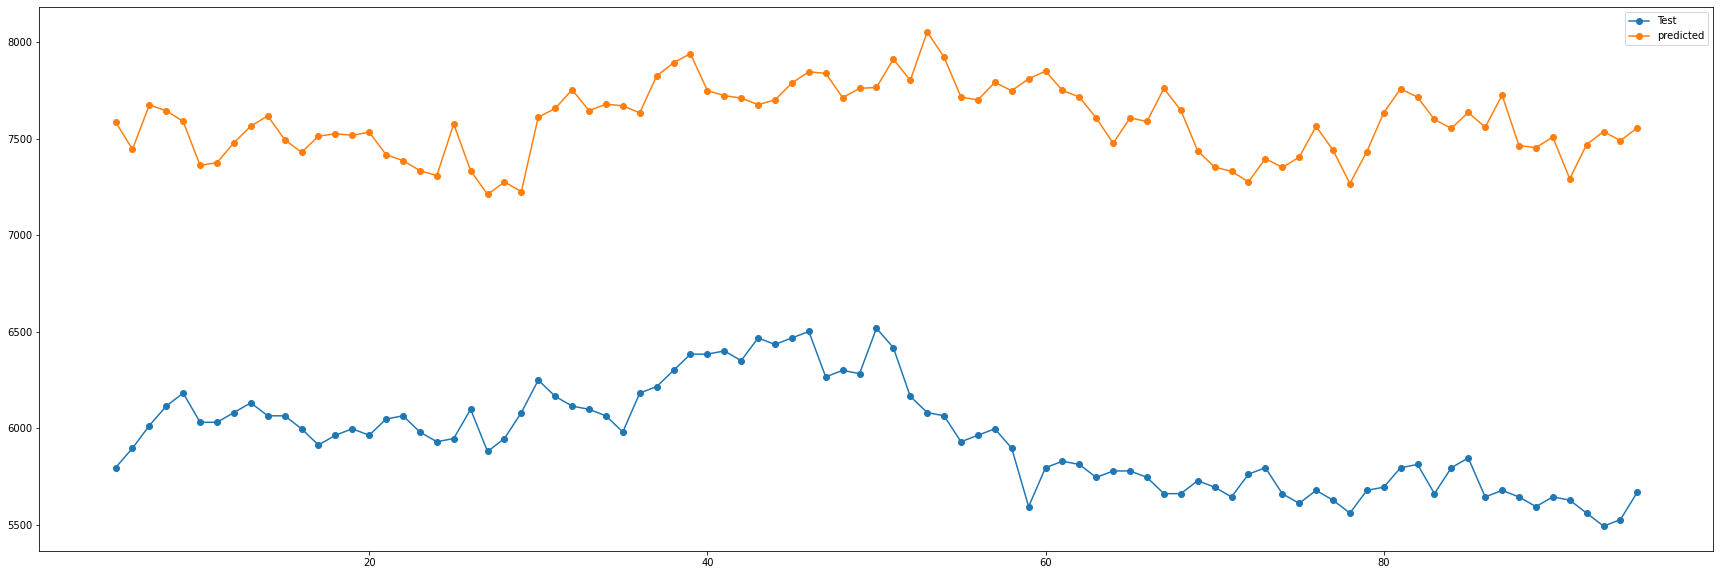

In [44]:
# predict, real 비교 plot
NP.predict_graph(dd['y_x'],dd['yhat1'])

In [18]:
# model save to disk
import pickle

filename = '/home/ykkim/Trained_Model/NeuralProphet_moorim_try2.sav'
pickle.dump(model, open(filename, 'wb'))